In [1]:
from Custom_tuning import *

In [2]:
from xgboost import XGBClassifier

In [3]:
class Custom_Tuning_CV():
    def __init__(self, metric, algorithm_instance, cross_validation_instance, num_trials=100, random_state=17):
        metrics = {"accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds"],
                    "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs"],
                    "mse": [lambda y, y_pred: mean_squared_error(y, y_pred), "preds"],
                    "rmse": [lambda y, y_pred: mean_squared_error(y, y_pred)**0.5, "preds"],
                    "mae": [lambda y, y_pred: mean_absolute_error(y, y_pred), "preds"]}
        if metric not in metrics:
            raise ValueError('Unsupported metric: {}'.format(metric))
        self.metric = metric
        self.eval_metric = metrics[self.metric][0]
        self.metric_type = metrics[self.metric][1]
        self.algorithm = algorithm_instance
        self.cv = cross_validation_instance
        self.num_trials = num_trials
        self.random_state = random_state
        np.random.seed(self.random_state)
        random.seed(self.random_state)
    
    def fit(self, X, y, params_dict, verbose=False):
        X = self.check_X(X=X)
        y = self.check_y(y=y)
        params_dict = self.check_params_dict(params_dict=params_dict)
        self.summary_frame_, self.best_params_ = self.perform_tuning(X=X, y=y, params_dict=params_dict, verbose=verbose)

    def check_X(self, X):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, np.ndarray) and not torch.is_tensor(X):
            raise TypeError('Wrong type of X. It should be dataframe, numpy array or torch tensor.')
        X = np.array(X)
        if(X.ndim == 1):
            X = X[None, :]
        return X
    
    def check_y(self, y):
        if not isinstance(y, pd.DataFrame) and not isinstance(y, pd.Series) and not isinstance(y, np.ndarray) and not torch.is_tensor(y):
            raise TypeError('Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array or torch tensor.')
        y = np.array(y)
        if(y.ndim == 2):
            y = y.squeeze()
        return y

    def check_params_dict(self, params_dict):
        if not isinstance(params_dict, dict):
            raise TypeError('Wrong type of params_dict. It should be dict.')
        return params_dict
    
    def perform_tuning(self, X, y, params_dict, verbose):
        all_selected_params, mean_of_train_scores, mean_of_valid_scores = [], [], []
        for trial in range(0, self.num_trials):
            current_params = {key: self.random_select(value[0], value[1]) for key, value in params_dict.items()}
            all_selected_params.append(current_params)
            train_scores, valid_scores = [], []
            for iter, (train_idx, valid_idx) in enumerate(self.cv.split(X, y)):
                X_train, X_valid = X[train_idx, :], X[valid_idx, :]
                y_train, y_valid = y[train_idx], y[valid_idx]
                model = self.algorithm.set_params(**current_params)
                model.fit(X_train, y_train)
                if(self.metric_type == "preds"):
                    y_train_pred = self.algorithm.predict(X_train)
                    y_valid_pred = self.algorithm.predict(X_valid)
                else:
                    y_train_pred = self.algorithm.predict_proba(X_train)[:, 1]
                    y_valid_pred = self.algorithm.predict_proba(X_valid)[:, 1]
                train_scores.append(self.eval_metric(y_train, y_train_pred))
                valid_scores.append(self.eval_metric(y_valid, y_valid_pred))
                if(verbose == True):
                    print("Iter {}: train scores: {}; valid scores: {}".format(iter, np.round(self.eval_metric(y_train, y_train_pred), 5), np.round(self.eval_metric(y_valid, y_valid_pred), 5)))
            mean_of_train_scores.append(np.mean(train_scores))
            mean_of_valid_scores.append(np.mean(valid_scores))
        summary_frame_ = pd.DataFrame.from_dict(all_selected_params)
        summary_frame_[f"Mean of Train {self.metric.upper()} Scores"] = mean_of_train_scores
        summary_frame_[f"Mean of Valid {self.metric.upper()} Scores"] = mean_of_valid_scores
        summary_frame_ = summary_frame_.sort_values(by=f"Mean of Valid {self.metric.upper()} Scores", ascending=False)
        best_params_ = {key: summary_frame_.loc[summary_frame_.index[0], key] for key in params_dict.keys()}
        return summary_frame_, best_params_
    
    def random_select(self, type, range):
        if(type == "categorical"):
            return random.choice(range)
        elif(type == "float"):
            return random.uniform(range[0], range[1])
        elif(type == "int"):
            return random.randint(range[0], range[1])
        else:
            raise ValueError(f"Unknown type: {type}. Permitted types are: `categorical`, `float`, `int`.")

In [4]:
from sklearn.preprocessing import OrdinalEncoder
data = pd.read_csv("Data/bank-balanced.csv")
X = data.drop("deposit", axis=1)
y = data["deposit"]
list_of_object_features_classification = data.select_dtypes(include="object").columns.tolist()
list_of_numeric_features_classification = data.select_dtypes(exclude="object").columns.tolist()
encoder = OrdinalEncoder()
data[list_of_object_features_classification] = encoder.fit_transform(data[list_of_object_features_classification])
target_binary = "deposit"
X = data.drop(target_binary, axis=1)
y = data[[target_binary]]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)

In [5]:
from sklearn.model_selection import StratifiedKFold, KFold
CV = Custom_Tuning_CV(metric="roc_auc", algorithm_instance=XGBClassifier(n_jobs=-1, random_state=17), cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17), num_trials=1000, random_state=17)
params_dict = {"n_estimators": ("int", [50, 250]),
                "learning_rate": ("float", [0.2, 0.35]),
                "reg_lambda": ("float", [2, 8]),
                "gamma": ("float", [3, 8]),
                "max_depth": ("int", [5, 30]),
                "colsample_bytree": ("float", [0.6, 0.8]),
                "subsample": ("float", [0.8, 0.9]),
                "min_child_weight": ("float", [2, 7])}
CV.fit(X=X_train, y=y_train, params_dict=params_dict)
CV.summary_frame_[:10]

KeyboardInterrupt: 

In [ ]:
from tabulate import tabulate
final_algorithm_optimized = XGBClassifier(n_jobs=-1, random_state=1)
final_algorithm_optimized.set_params(**CV.best_params_)
final_algorithm_optimized.fit(X_train, np.array(y_train).squeeze())
y_pred_final_optimized = final_algorithm_optimized.predict(X_test)
y_prob_final_optimized = final_algorithm_optimized.predict_proba(X_test)[:, 1]
print("Balance accuracy score: {}".format(np.round(balanced_accuracy_score(y_true=y_test, y_pred=y_pred_final_optimized), 5)))
print("Roc AUC score: {}".format(np.round(roc_auc_score(y_true=y_test, y_score=y_prob_final_optimized), 5)))
report = classification_report(y_test, y_pred_final_optimized, output_dict=True)
df = pd.DataFrame(report).transpose()
print(tabulate(df, headers="keys", tablefmt = 'psql'))

Balance accuracy score: 0.86536
Roc AUC score: 0.92943
+--------------+-------------+----------+------------+-------------+
|              |   precision |   recall |   f1-score |     support |
|--------------+-------------+----------+------------+-------------|
| 0.0          |    0.885482 | 0.848747 |   0.866726 | 1157        |
| 1.0          |    0.844306 | 0.88197  |   0.862727 | 1076        |
| accuracy     |    0.864756 | 0.864756 |   0.864756 |    0.864756 |
| macro avg    |    0.864894 | 0.865359 |   0.864726 | 2233        |
| weighted avg |    0.865641 | 0.864756 |   0.864799 | 2233        |
+--------------+-------------+----------+------------+-------------+


In [6]:
from statsmodels.tsa.stattools import adfuller, kpss
data = pd.read_csv("Data/licencjat_binance_7.csv", index_col=0)
X = data.drop("TARGET", axis=1)
y = data["TARGET"]
features_to_keep = []
columns_to_be_checked = X.columns.tolist()
columns_to_be_checked.remove("Price_Change_pct")
columns_to_be_checked.remove('PREV_TARGET')
for feature in columns_to_be_checked:
    X_copy = X.copy()
    X[feature] = X[feature].diff(periods=1)
    X_copy[feature] = X_copy[feature].diff(periods=1)
    X_copy.dropna(inplace=True)
    if(adfuller(X_copy[feature].values, autolag='AIC')[1] < 0.05):
        features_to_keep.append(feature)
features_to_keep.append("Price_Change_pct")
features_to_keep.append("PREV_TARGET")
X = X[features_to_keep]
X.dropna(inplace=True)
y = y[1:]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, random_state=17, test_size=0.2)

In [8]:
model = XGBClassifier(n_jobs=-1, random_state=17)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred), model.feature_importances_

(0.5260273972602739,
 array([0.05020253, 0.04693231, 0.04929454, 0.04652989, 0.05724261,
        0.05342221, 0.052189  , 0.05606652, 0.06829931, 0.05226037,
        0.05629469, 0.04093371, 0.04941618, 0.        , 0.0469419 ,
        0.05978026, 0.0619368 , 0.04921516, 0.0468547 , 0.05618729,
        0.        ], dtype=float32))

<BarContainer object of 21 artists>

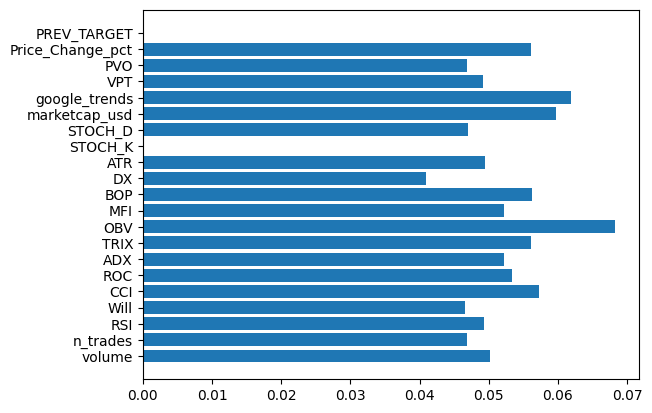

In [9]:
from matplotlib import pyplot as plt
plt.barh(X.columns, model.feature_importances_)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
CV = Custom_Tuning_CV(metric="roc_auc", algorithm_instance=XGBClassifier(n_jobs=-1, random_state=17), cross_validation_instance=TimeSeriesSplit(n_splits=5), num_trials=100, random_state=17)
params_dict = {"n_estimators": ("int", [50, 200]),
                "learning_rate": ("float", [0.05, 0.4]),
                "reg_lambda": ("float", [3, 15]),
                "gamma": ("float", [3, 15]),
                "max_depth": ("int", [15, 45]),
                "colsample_bytree": ("float", [0.7, 0.9]),
                "subsample": ("float", [0.7, 0.9]),
                "min_child_weight": ("float", [1, 5])}
CV.fit(X=X_train, y=y_train, params_dict=params_dict)
CV.summary_frame_[:10]

,n_estimators,learning_rate,reg_lambda,gamma,max_depth,colsample_bytree,subsample,min_child_weight,Mean of Train ROC_AUC Scores,Mean of Valid ROC_AUC Scores
75,133,0.063077,11.778376,6.645043,18,0.716989,0.817280,3.000565,0.718753,0.564677
9,135,0.053417,12.039233,7.176048,29,0.848929,0.794762,1.215824,0.702090,0.554433
54,89,0.316705,3.851744,6.866661,16,0.870557,0.868391,4.810945,0.864919,0.554428
8,114,0.280498,13.998351,6.826548,25,0.718823,0.814983,4.129606,0.710699,0.553464
32,82,0.151037,5.911219,6.007734,21,0.774492,0.827094,2.340001,0.850685,0.552931
68,58,0.175162,11.577351,5.257270,39,0.765288,0.741964,1.699902,0.783069,0.552500
2,152,0.098139,9.614213,4.678580,40,0.875063,0.730183,3.822274,0.856654,0.552155
43,173,0.084813,14.914954,8.960497,23,0.794432,0.739758,2.026304,0.607934,0.551321
85,143,0.054231,9.986671,5.677292,41,0.726514,0.789266,4.689233,0.780464,0.549512
89,126,0.069268,11.278289,5.001084,42,0.822874,0.871956,1.448856,0.819250,0.549292


In [ ]:
from tabulate import tabulate
final_algorithm_optimized = XGBClassifier(n_jobs=-1, random_state=1)
final_algorithm_optimized.set_params(**CV.best_params_)
final_algorithm_optimized.fit(X_train, np.array(y_train).squeeze())
y_pred_final_optimized = final_algorithm_optimized.predict(X_test)
y_prob_final_optimized = final_algorithm_optimized.predict_proba(X_test)[:, 1]
print("Balance accuracy score: {}".format(np.round(balanced_accuracy_score(y_true=y_test, y_pred=y_pred_final_optimized), 5)))
print("Roc AUC score: {}".format(np.round(roc_auc_score(y_true=y_test, y_score=y_prob_final_optimized), 5)))
report = classification_report(y_test, y_pred_final_optimized, output_dict=True)
df = pd.DataFrame(report).transpose()
print(tabulate(df, headers="keys", tablefmt = 'psql'))

Balance accuracy score: 0.52949
Roc AUC score: 0.57683
+--------------+-------------+----------+------------+------------+
|              |   precision |   recall |   f1-score |    support |
|--------------+-------------+----------+------------+------------|
| 0.0          |    0.578512 | 0.358974 |   0.443038 | 195        |
| 1.0          |    0.487705 | 0.7      |   0.574879 | 170        |
| accuracy     |    0.517808 | 0.517808 |   0.517808 |   0.517808 |
| macro avg    |    0.533109 | 0.529487 |   0.508959 | 365        |
| weighted avg |    0.536219 | 0.517808 |   0.504443 | 365        |
+--------------+-------------+----------+------------+------------+


In [ ]:
Balance accuracy score: 0.55106
Roc AUC score: 0.59149